In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import math
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
from itertools import zip_longest
from scipy.stats import linregress


dat_path = os.getcwd()[:-12] + 'Data/'
fig_path = os.getcwd()[:-4] + 'figures/preliminary/'
generated_dat_path = os.getcwd()[:-12] + 'Data/generated_data/'

text_font = 30

In [2]:
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [3]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [4]:
def captain_non_captain_data(min_career, norm_quant, category, min_captain):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'])

    captain_category, non_captain_category = [], []

    for player in tqdm(players_list):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')

        if category == 'bat':
            if temp_df['batsmen'].sum() > min_career:
                if temp_df['captain'].sum() > min_captain:
                    captain_category.append(temp_df['renormalized_bat_run'].mean())
                else:
                    non_captain_category.append(temp_df['renormalized_bat_run'].mean())

        if category == 'bowl':
            if temp_df['bowler'].sum() > min_career:
                if temp_df['captain'].sum() > min_captain:
                    captain_category.append(temp_df['bowl_wickets'].mean())
                else:
                    non_captain_category.append(temp_df['bowl_wickets'].mean())

    with open(generated_dat_path + f'captain_non_captain_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl', 'wb') as f:
        pickle.dump([captain_category, non_captain_category], f)

# captain_non_captain_data(min_career=25, norm_quant='Runs', category='bat', min_captain=50)
# captain_non_captain_data(min_career=25, norm_quant='Runs', category='bowl', min_captain=50)

bat 49 544
31.766024523688095 25.455528052747354
0.1986555310449682
bowl 22 550
0.9479182064547917 1.151844532279315
-0.21513071954510335


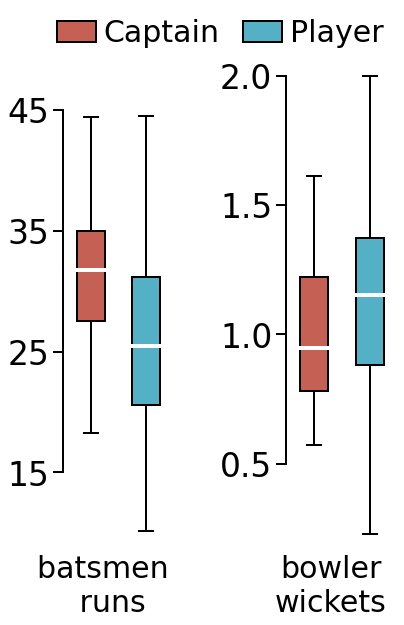

In [5]:
def captain_non_captain_plot(min_career, norm_quant, min_captain):

    fig, ax = plt.subplots(1,2,figsize=(6, 10))
    plt.subplots_adjust(wspace=1, hspace=0.5)
    ax = ax.flatten()

    for i, category in enumerate(['bat', 'bowl']):
        with open(generated_dat_path + f'captain_non_captain_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl', 'rb') as f:
            captain_category, non_captain_category = pickle.load(f)

        
        bplot1 = ax[i].boxplot([captain_category], positions=[1], widths=0.5, showfliers=False, patch_artist=True,
                    boxprops=dict(facecolor='#C56054', linewidth=2), 
                    medianprops=dict(color='white', linewidth=4), 
                    whiskerprops=dict(color='black', linewidth=2), 
                    capprops=dict(color='black', linewidth=2))
        bplot2 = ax[i].boxplot([non_captain_category], positions=[2], widths=0.5, showfliers=False, patch_artist=True,
                    boxprops=dict(facecolor='#54B0C5', linewidth=2), 
                    medianprops=dict(color='white', linewidth=4), 
                    whiskerprops=dict(color='black', linewidth=2), 
                    capprops=dict(color='black', linewidth=2))
        
        print(category, len(captain_category), len(non_captain_category))
        print(np.nanmedian(captain_category), np.nanmedian(non_captain_category))
        print((np.nanmedian(captain_category)- np.nanmedian(non_captain_category))/(np.nanmedian(captain_category)))
    
        axis_decor(ax[i], text_font+3, 10, 5, 2)

        ax[i].set_xticks([])
        ax[i].set_xticklabels([])
        ax[i].spines['bottom'].set_visible(False)

        if category == 'bat':
            ax[i].set_ylim(5, 50)
            ax[i].set_yticks([15, 25, 35, 45])
            ax[i].spines['left'].set_bounds(15, 45)
            ax[i].set_xlabel('batsmen \n runs', fontsize=text_font, horizontalalignment='center')
            ax[i].xaxis.set_label_coords(0.4, 0.07)
        elif category == 'bowl':
            ax[i].set_ylim(0, 2.1)
            ax[i].set_yticks([0.5, 1, 1.5, 2])
            ax[i].spines['left'].set_bounds(0.5, 2)
            ax[i].set_xlabel('bowler\nwickets', fontsize=text_font, horizontalalignment='center')
            ax[i].xaxis.set_label_coords(0.4, 0.07)


    fig.legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['Captain', 'Player'], loc='upper right', fontsize=text_font, frameon=False, bbox_to_anchor=(0.73,0.76,0.2, 0.2), ncol=2, labelspacing=1, columnspacing=0.8, handletextpad=0.25, handlelength=1.3)

    # plt.tight_layout()
    plt.savefig(fig_path + f'captain_non_captain_min_career_{min_career}_renorm_{norm_quant}_min_captain_{min_captain}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(fig_path + f'captain_non_captain_min_career_{min_career}_renorm_{norm_quant}_min_captain_{min_captain}.jpeg', format='jpeg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

captain_non_captain_plot(min_career=25, norm_quant='Runs', min_captain=50)

In [6]:
def captain_division_data(min_career, norm_quant, category, min_captain):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'])

    before_captain_category, during_captain_category, after_captain_category = [], [], []

    for player in tqdm(players_list):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')

        if category == 'bat':
            if temp_df['batsmen'].sum() > min_career:
                captain_indices = temp_df[temp_df['captain'] == 1].index.tolist()
                if len(captain_indices) > min_captain:
                    # print(player, len(captain_indices))
                    first_captain_index = captain_indices[0]
                    last_captain_index = captain_indices[-1]
                    before_captain_category.append(temp_df[temp_df.index < first_captain_index]['renormalized_bat_run'].mean())
                    during_captain_category.append(temp_df[(temp_df.index >= first_captain_index) & (temp_df.index <= last_captain_index)]['renormalized_bat_run'].mean())
                    after_captain_category.append(temp_df[temp_df.index > last_captain_index]['renormalized_bat_run'].mean())

        if category == 'bowl':
            if temp_df['bowler'].sum() > min_career:
                captain_indices = temp_df[temp_df['captain'] == 1].index.tolist()
                if len(captain_indices) > min_captain:
                    # print(player, len(captain_indices))
                    first_captain_index = captain_indices[0]
                    last_captain_index = captain_indices[-1]
                    before_captain_category.append(temp_df[temp_df.index < first_captain_index]['bowl_wickets'].mean())
                    during_captain_category.append(temp_df[(temp_df.index >= first_captain_index) & (temp_df.index <= last_captain_index)]['bowl_wickets'].mean())
                    after_captain_category.append(temp_df[temp_df.index > last_captain_index]['bowl_wickets'].mean())

    with open(generated_dat_path + f'captain_before_during_after_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl', 'wb') as f:
        pickle.dump([before_captain_category, during_captain_category, after_captain_category], f)

# captain_division_data(min_career=25, norm_quant='Runs', category='bat', min_captain=50)
# captain_division_data(min_career=25, norm_quant='Runs', category='bowl', min_captain=50)

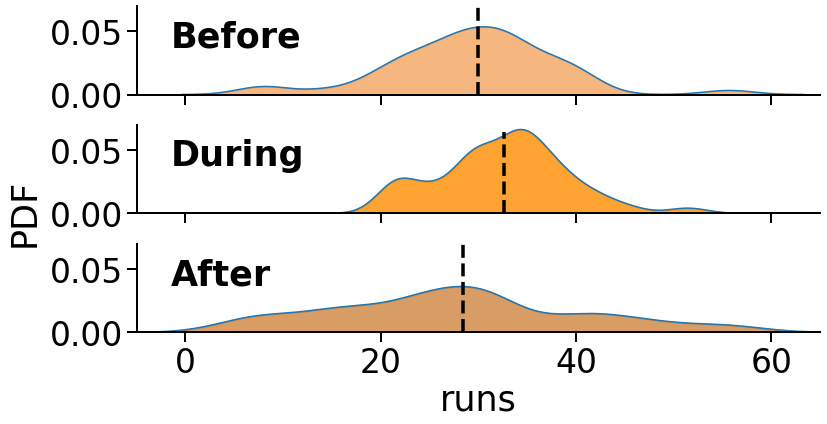

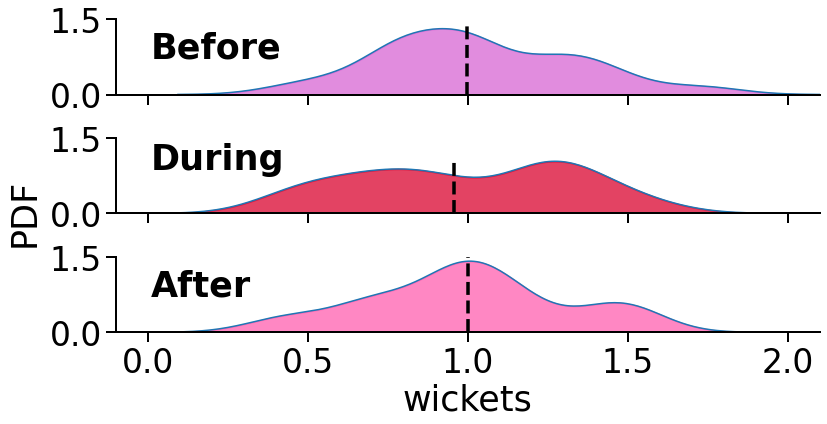

In [7]:
def captain_division_plot(min_career, norm_quant, category,  min_captain, bw_val):
    
    data = pd.read_pickle(generated_dat_path + f'captain_before_during_after_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl')

    time_period = ['Before', 'During', 'After']

    # Creating a new figure
    fig, axes = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=True)
    # color_list = ['lightcoral', 'firebrick', 'indianred']#['#C56054', '#F2B035', '#54B0C5']

    if category == 'bat':
        color_list = ['sandybrown', 'darkorange', 'peru']
    elif category == 'bowl':
        color_list = ['orchid', 'crimson', 'hotpink']

    # Removing gridlines and ticks for the top two panels
    # for ax in axes:
    #     ax.grid(False)
    #     ax.set_yticks([])

    # Plotting the densities and the mean lines
    for i, tp in enumerate(time_period):

        cat_data = [x for x in data[i] if ~np.isnan(x)  and x > 0]
    
    
        sns.kdeplot(cat_data, shade=True, alpha=0.8, lw=1.5, bw_method=bw_val, ax=axes[i], color = color_list[i])
    
        # Calculating the mean and plotting a white line
        median_val = np.nanmedian(cat_data)
        mean_density = sns.kdeplot(cat_data, bw_method=bw_val, ax=axes[i]).get_lines()[0].get_data()
        
        # Find the index of the x-value closest to the mean
        ind = (np.abs(mean_density[0]-median_val)).argmin()
        
        y_val = mean_density[1][ind]/max(mean_density[1])
        
        axes[i].axvline(x = median_val, ymin=0, ymax=1*y_val, color='black', lw=3.5, ls='--')

        axis_decor(axes[i], text_font+3, 10, 5, 2)

        axes[i].set_ylabel('')

        if category == 'bat':
            axes[i].set_xlim(-5, 65)
            axes[i].set_xlabel('runs', fontsize=text_font+5)
        elif category == 'bowl':
            axes[i].set_xlim(-0.1, 2.1)
            axes[i].set_yticks([0, 1.5])
            axes[i].set_xlabel('wickets', fontsize=text_font+5)

        if category == 'bowl' and tp == 'During':
            axes[i].text(0.05, 0.95, tp, transform=axes[i].transAxes, fontsize=text_font+5, fontweight='bold', va='top', ha='left')
        else:
            axes[i].text(0.05, 0.85, tp, transform=axes[i].transAxes, fontsize=text_font+5, fontweight='bold', va='top', ha='left')

    fig.text(-0.04, 0.5, 'PDF', va='center', rotation='vertical', fontsize=text_font+5)
    plt.tight_layout()
    plt.savefig(fig_path + f'captain_division_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    

captain_division_plot(min_career=25, norm_quant='Runs', category='bat', min_captain=50, bw_val=0.3)
captain_division_plot(min_career=25, norm_quant='Runs', category='bowl', min_captain=50, bw_val=0.4)

In [8]:
# def captain_zscore_data(norm_quant, captain_match_threshold):
#     odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}.csv')

#     odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

#     players_list = np.unique(odi_final['player_name'])

#     z_score = []
#     win_loss = []

#     for player in tqdm(players_list):
#         temp_df = odi_final[odi_final['player_name'] == player]
#         temp_df = temp_df.sort_values(by='Match_Date')

#         captain_indices = temp_df[temp_df['captain'] == 1].index.tolist()

#         bat_category = 1 if temp_df['renormalized_bat_run'].sum() > 1000 else 0
#         bowl_category = 1 if temp_df['bowl_wickets'].sum() > 50 else 0

#         if len(captain_indices) > captain_match_threshold:

#             cap_during_df = temp_df[(temp_df.index >= captain_indices[0]) & (temp_df.index <= captain_indices[-1])]

#             if bat_category == 1:
#                 mu_bat = cap_during_df['renormalized_bat_run'].mean()
#                 sigma_bat = cap_during_df['renormalized_bat_run'].std()

#                 temp_z_score = [(x - mu_bat) / sigma_bat for x in cap_during_df['renormalized_bat_run']]
#                 temp_win_loss = [1 if team == winner else 0 for team, winner in zip(cap_during_df['Team'], cap_during_df['Winner'])]

#                 z_score.append(temp_z_score)
#                 win_loss.append(temp_win_loss)

#             if bowl_category == 1:
#                 mu_bowl = cap_during_df['bowl_wickets'].mean()
#                 sigma_bowl = cap_during_df['bowl_wickets'].mean()

#                 temp_z_score = [(x - mu_bowl) / sigma_bowl for x in cap_during_df['bowl_wickets']]
#                 temp_win_loss = [1 if team == winner else 0 for team, winner in zip(cap_during_df['Team'], cap_during_df['Winner'])]

#                 z_score.append(temp_z_score)
#                 win_loss.append(temp_win_loss)

#     z_score = [item for sublist in z_score for item in sublist]
#     win_loss = [item for sublist in win_loss for item in sublist]

#     with open(dat_path + f'captain_zscore_win_loss_{norm_quant}_min_captain_{captain_match_threshold}.pkl', 'wb') as f:
#         pickle.dump([z_score, win_loss], f)

# # captain_zscore_data('Runs', 50)

In [9]:
# def captain_zscore_plot(norm_quant, captain_match_threshold):

#     fig, ax = plt.subplots(1,1,figsize=(4, 7))

#     color_list = ['#99B162', '#E05E37']

#     with open(dat_path + f'captain_zscore_win_loss_{norm_quant}_min_captain_{captain_match_threshold}.pkl', 'rb') as f:
#         z_score, win_loss = pickle.load(f)

#     win_loss = np.array(win_loss)
#     z_score = np.array(z_score)

#     # Create a mask for valid z_score values
#     mask = ~np.isnan(z_score)

#     # Use the mask to index both win_loss and z_score
#     win_loss = win_loss[mask]
#     z_score = z_score[mask]

#     win_ind = np.where(win_loss == 1)[0]
#     loss_ind = np.where(win_loss == 0)[0]

#     vp = ax.violinplot([z_score[win_ind], z_score[loss_ind]], positions=[0.25, 0.75], widths=0.4, 
#                   showmeans=False, showmedians=True, showextrema=False)
    
#     # Set the colors
#     for i, body in enumerate(vp['bodies']):
#         body.set_facecolor(color_list[i])
#         body.set_alpha(0.8)
#         body.set_edgecolor('black')


#     vp['cmedians'].set_color('white')
#     vp['cmedians'].set_linewidth(3)


#     ax.set_xticks([0.25, 0.75])
#     ax.set_xticklabels(['Win', 'Loss'])
#     ax.set_ylabel('performance z-score', fontsize=text_font)

#     axis_decor(ax, text_font, 10, 5, 2)

#     plt.tight_layout()
#     plt.savefig(fig_path + f'captain_zscore_{norm_quant}_min_captain_{captain_match_threshold}.pdf', dpi=300, format = 'pdf', bbox_inches='tight')
#     plt.show()
#     plt.close()

# # captain_zscore_plot('Runs', 50)

In [10]:
# def captain_burden_data(norm_quant, captain_match_threshold):
#     odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}.csv')

#     odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

#     players_list = np.unique(odi_final['player_name'])

#     #### create a list of true captains
#     temp_captain = odi_final[odi_final['captain'] == 1]
#     all_captains_list = np.unique(temp_captain['player_name'])

#     captains_final_list = []

#     for captain in all_captains_list:
#         temp_df = odi_final[odi_final['player_name'] == captain]
#         if len(temp_df) > captain_match_threshold:
#             captains_final_list.append(captain)
#     ##################################################

#     team_contribution = []
#     win_loss = []

#     unique_match_id = []

#     for captain in tqdm(captains_final_list):
#         temp_df = odi_final[odi_final['player_name'] == captain]
#         temp_df = temp_df.sort_values(by='Match_Date')

#         captain_indices = temp_df[temp_df['captain'] == 1].index.tolist()

#         cap_during_df = temp_df[(temp_df.index >= captain_indices[0]) & (temp_df.index <= captain_indices[-1])]

#         match_id = np.unique(cap_during_df['Match_ID'])

#         for match in match_id:
#             if match not in unique_match_id:
#                 temp_match_df = odi_final[odi_final['Match_ID'] == match]
#                 cap1_bat, cap2_bat, cap1_bowl, cap2_bowl = 0, 0, 0, 0

#                 two_teams = np.unique(temp_match_df['Team'])

#                 team1_df = temp_match_df[temp_match_df['Team'] == two_teams[0]]
#                 team1_df = team1_df[team1_df['captain'] == 1]

#                 team2_df = temp_match_df[temp_match_df['Team'] == two_teams[1]]
#                 team2_df = team2_df[team2_df['captain'] == 1]

#                 cap1_bat = team1_df['renormalized_bat_run'].values[0]/team1_df['renormalized_runs'].values[0]
#                 cap2_bat = team2_df['renormalized_bat_run'].values[0]/team2_df['renormalized_runs'].values[0]

#                 cap1_bowl = team1_df['bowl_wickets'].values[0]/team2_df['Wickets'].values[0]
#                 cap2_bowl = team2_df['bowl_wickets'].values[0]/team1_df['Wickets'].values[0]

#                 cap1_bat = 0 if np.isnan(cap1_bat) else cap1_bat
#                 cap2_bat = 0 if np.isnan(cap2_bat) else cap2_bat
#                 cap1_bowl = 0 if np.isnan(cap1_bowl) else cap1_bowl
#                 cap2_bowl = 0 if np.isnan(cap2_bowl) else cap2_bowl

#                 if team1_df['player_name'].values[0] in captains_final_list:
#                     team_contribution.append(np.mean([cap1_bat, cap1_bowl]))
#                     win_loss.append(1 if team1_df['Winner'].values[0] == team1_df['Team'].values[0] else 0)

#                 if team2_df['player_name'].values[0] in captains_final_list:
#                     team_contribution.append(np.mean([cap2_bat, cap2_bowl]))
#                     win_loss.append(1 if team2_df['Winner'].values[0] == team2_df['Team'].values[0] else 0)

#                 unique_match_id.append(match)

#     with open(dat_path + f'captain_burden_{norm_quant}_min_captain_{captain_match_threshold}.pkl', 'wb') as f:
#         pickle.dump([team_contribution, win_loss], f)

# # captain_burden_data('Runs', 50)

In [11]:
# def captain_burden_plot(norm_quant, captain_match_threshold):

#     fig, ax = plt.subplots(1,1,figsize=(4, 7))

#     color_list = ['#99B162', '#E05E37']

#     with open(dat_path + f'captain_burden_{norm_quant}_min_captain_{captain_match_threshold}.pkl', 'rb') as f:
#         team_contribution, win_loss = pickle.load(f)

#     win_loss = np.array(win_loss)
#     team_contribution = np.array(team_contribution)

#     # Create a mask for valid z_score values
#     mask = ~np.isnan(team_contribution)

#     # Use the mask to index both win_loss and z_score
#     win_loss = win_loss[mask]
#     team_contribution = team_contribution[mask]

#     win_ind = np.where(win_loss == 1)[0]
#     loss_ind = np.where(win_loss == 0)[0]
    
#     bplot1 = ax.boxplot([team_contribution[win_ind], team_contribution[loss_ind]], 
#                     positions=[0.2, 0.8], widths=0.35, showfliers=False, patch_artist=True,
#                     boxprops=dict(facecolor='#C56054', linewidth=2), 
#                     medianprops=dict(color='white', linewidth=3), 
#                     whiskerprops=dict(color='black', linewidth=2), 
#                     capprops=dict(color='black', linewidth=2))
    
#     for patch, color in zip(bplot1['boxes'], color_list):
#         patch.set_facecolor(color)


#     ax.set_xticks([0.2, 0.8])
#     ax.set_xticklabels(['Win', 'Loss'])
#     ax.set_ylabel('team load', fontsize=text_font)

#     axis_decor(ax, text_font, 10, 5, 2)

#     plt.tight_layout()
#     plt.savefig(fig_path + f'captain_burden_{norm_quant}_min_captain_{captain_match_threshold}.pdf', dpi=300, format = 'pdf', bbox_inches='tight')
#     plt.show()
#     plt.close()

# # captain_burden_plot('Runs', 50)

In [12]:
# def captain_crossover_data(min_career, norm_quant, min_captain_match, history, avg):
#     odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}.csv')

#     odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

#     players_list = np.unique(odi_final['player_name'])

#     before_captain_bat, first_captain_bat, last_captain_bat, after_captain_bat = [ [[] for i in range(history)] for j in range(4)]
#     before_captain_bowl, first_captain_bowl, last_captain_bowl, after_captain_bowl = [ [[] for i in range(history)] for j in range(4)]

#     for player in tqdm(players_list):
#         temp_df = odi_final[odi_final['player_name'] == player]
#         temp_df = temp_df.sort_values(by='Match_ID')

#         temp_df.index = range(len(temp_df))


#         if temp_df['captain'].sum() > min_captain_match:

#             captain_indices = temp_df[temp_df['captain'] == 1].index.tolist()
#             first_captain_index = captain_indices[0]
#             last_captain_index = captain_indices[-1]

#             if temp_df['renormalized_bat_run'].sum() > 1000:
    
#                 for h in range(history):

#                     if (first_captain_index > history+1):

#                         if avg == 'no':

#                             before_captain_bat[h].append(temp_df.iloc[first_captain_index-1-h, temp_df.columns.get_loc('renormalized_bat_run')])
#                             first_captain_bat[h].append(temp_df.iloc[first_captain_index+h, temp_df.columns.get_loc('renormalized_bat_run')])

#                         elif avg == 'yes':

#                             before_captain_bat[h].append(np.nanmean(temp_df.iloc[first_captain_index-1-h:first_captain_index, temp_df.columns.get_loc('renormalized_bat_run')]))
#                             first_captain_bat[h].append(np.nanmean(temp_df.iloc[first_captain_index:first_captain_index+h+1, temp_df.columns.get_loc('renormalized_bat_run')]))

#                     if (last_captain_index + history +1 < len(temp_df)):

#                         if avg == 'no':

#                             last_captain_bat[h].append(temp_df.iloc[last_captain_index-h, temp_df.columns.get_loc('renormalized_bat_run')])
#                             after_captain_bat[h].append(temp_df.iloc[last_captain_index+1+h, temp_df.columns.get_loc('renormalized_bat_run')])

#                         elif avg == 'yes':

#                             last_captain_bat[h].append(np.nanmean(temp_df.iloc[last_captain_index-h:last_captain_index+1, temp_df.columns.get_loc('renormalized_bat_run')]))
#                             after_captain_bat[h].append(np.nanmean(temp_df.iloc[last_captain_index+1:last_captain_index+2+h, temp_df.columns.get_loc('renormalized_bat_run')]))

#             if temp_df['bowl_wickets'].sum() > 50:

#                 for h in range(history):

#                     if (first_captain_index > history+1):

#                         if avg == 'no':

#                             before_captain_bowl[h].append(temp_df.iloc[first_captain_index-1-h, temp_df.columns.get_loc('bowl_wickets')])
#                             first_captain_bowl[h].append(temp_df.iloc[first_captain_index+h, temp_df.columns.get_loc('bowl_wickets')])

#                         elif avg == 'yes':

#                             before_captain_bowl[h].append(np.nanmean(temp_df.iloc[first_captain_index-1-h:first_captain_index, temp_df.columns.get_loc('bowl_wickets')]))
#                             first_captain_bowl[h].append(np.nanmean(temp_df.iloc[first_captain_index:first_captain_index+h+1, temp_df.columns.get_loc('bowl_wickets')]))

#                     if (last_captain_index + history +1 < len(temp_df)):

#                         if avg == 'no':

#                             last_captain_bowl[h].append(temp_df.iloc[last_captain_index-h, temp_df.columns.get_loc('bowl_wickets')])
#                             after_captain_bowl[h].append(temp_df.iloc[last_captain_index+1+h, temp_df.columns.get_loc('bowl_wickets')])

#                         elif avg == 'yes':

#                             last_captain_bowl[h].append(np.nanmean(temp_df.iloc[last_captain_index-h:last_captain_index+1, temp_df.columns.get_loc('bowl_wickets')]))
#                             after_captain_bowl[h].append(np.nanmean(temp_df.iloc[last_captain_index+1:last_captain_index+2+h, temp_df.columns.get_loc('bowl_wickets')]))


#     with open(dat_path + f'captain_crossover_{norm_quant}_min_captain_{min_captain_match}_history_{history}_avg_{avg}.pkl', 'wb') as f:
#         pickle.dump([before_captain_bat, first_captain_bat, last_captain_bat, after_captain_bat, before_captain_bowl, first_captain_bowl, last_captain_bowl, after_captain_bowl], f)

# # captain_crossover_data(0, 'Runs', 50, 5)
# # captain_crossover_data(0, 'Runs', 50, 3)
# # captain_crossover_data(0, 'Runs', 50, 10, 'yes')
# # captain_crossover_data(0, norm_quant='Runs', min_captain_match= 50, history= 20, avg='no')

In [13]:
# def captain_crossover_plot(min_career, norm_quant, min_captain_match, history, category, avg):

#     with open(dat_path + f'captain_crossover_{norm_quant}_min_captain_{min_captain_match}_history_{history}_avg_{avg}.pkl', 'rb') as f:
#         before_captain_bat, first_captain_bat, last_captain_bat, after_captain_bat, before_captain_bowl, first_captain_bowl, last_captain_bowl, after_captain_bowl = pickle.load(f)

#     fig, ax = plt.subplots(1,1,figsize=(10, 6))

#     if category == 'bat':

#         before_captain_bat_dat = [np.nanmean(x) for x in before_captain_bat]
#         first_captain_bat_dat = [np.nanmean(x) for x in first_captain_bat]
#         last_captain_bat_dat = [np.nanmean(x) for x in last_captain_bat]
#         after_captain_bat_dat = [np.nanmean(x) for x in after_captain_bat]

#         before_captain_bat_err = [np.nanstd(x)/len(x) for x in before_captain_bat]
#         first_captain_bat_err = [np.nanstd(x)/len(x) for x in first_captain_bat]
#         last_captain_bat_err = [np.nanstd(x)/len(x) for x in last_captain_bat]
#         after_captain_bat_err = [np.nanstd(x)/len(x) for x in after_captain_bat]

#         before_captain_bat_arr = np.array(before_captain_bat)
#         first_captain_bat_arr = np.array(first_captain_bat)
#         last_captain_bat_arr = np.array(last_captain_bat)
#         after_captain_bat_arr = np.array(after_captain_bat)



#         for i in range(len(before_captain_bat_arr[0,:])):
#             ax.plot(np.arange(history), before_captain_bat_arr[:,i][::-1], color='red', alpha=0.2, linewidth=1)
#         for i in range(len(first_captain_bat_arr[0,:])):
#             ax.plot(history+1+np.arange(history), first_captain_bat_arr[:,i], color='darkred', alpha=0.2, linewidth=1)

#         for i in range(len(last_captain_bat_arr[0,:])):
#             ax.plot(np.arange(history), last_captain_bat_arr[:,i][::-1], color='blue', alpha=0.2, linewidth=1)
#         for i in range(len(after_captain_bat_arr[0,:])):
#             ax.plot(history+1+np.arange(history), after_captain_bat_arr[:,i], color='darkblue', alpha=0.2, linewidth=1)


#         ax.errorbar(np.arange(history), before_captain_bat_dat[::-1], yerr=before_captain_bat_err[::-1], fmt='o', color='red', linestyle='-')
#         ax.errorbar(history+1+np.arange(history), first_captain_bat_dat, yerr=first_captain_bat_err, fmt='o', color='darkred', linestyle='-')

#         ax.errorbar(np.arange(history), last_captain_bat_dat[::-1], yerr=last_captain_bat_err[::-1], fmt='o', color='blue', linestyle='-')
#         ax.errorbar(history+1+np.arange(history), after_captain_bat_dat, yerr=after_captain_bat_err, fmt='o', color='darkblue', linestyle='-')

#         ax.add_line(mpl.lines.Line2D([history-1, history+1], [before_captain_bat_dat[0], first_captain_bat_dat[0]], color='indianred', linewidth=3, linestyle='--', label='new captain'))

#         ax.add_line(mpl.lines.Line2D([history-1, history+1], [last_captain_bat_dat[0], after_captain_bat_dat[0]], color='navy', linewidth=3, linestyle='--', label='old captain'))

#         ax.text(18.75, 65, 'transition', fontsize=text_font+5, color='darkorange', fontweight='bold', rotation=90)


#     elif category == 'bowl':

#         before_captain_bowl_dat = [np.nanmean(x) for x in before_captain_bowl]
#         first_captain_bowl_dat = [np.nanmean(x) for x in first_captain_bowl]
#         last_captain_bowl_dat = [np.nanmean(x) for x in last_captain_bowl]
#         after_captain_bowl_dat = [np.nanmean(x) for x in after_captain_bowl]

#         before_captain_bowl_err = [np.nanstd(x)/len(x) for x in before_captain_bowl]
#         first_captain_bowl_err = [np.nanstd(x)/len(x) for x in first_captain_bowl]
#         last_captain_bowl_err = [np.nanstd(x)/len(x) for x in last_captain_bowl]
#         after_captain_bowl_err = [np.nanstd(x)/len(x) for x in after_captain_bowl]

#         before_captain_bowl_arr = np.array(before_captain_bowl)
#         first_captain_bowl_arr = np.array(first_captain_bowl)
#         last_captain_bowl_arr = np.array(last_captain_bowl)
#         after_captain_bowl_arr = np.array(after_captain_bowl)

#         for i in range(len(before_captain_bowl_arr[0,:])):
#             ax.plot(np.arange(history), before_captain_bowl_arr[:,i][::-1], color='red', alpha=0.2, linewidth=1)
#         for i in range(len(first_captain_bowl_arr[0,:])):
#             ax.plot(history+1+np.arange(history), first_captain_bowl_arr[:,i], color='darkred', alpha=0.2, linewidth=1)

#         for i in range(len(last_captain_bowl_arr[0,:])):
#             ax.plot(np.arange(history), last_captain_bowl_arr[:,i][::-1], color='blue', alpha=0.2, linewidth=1)
#         for i in range(len(after_captain_bowl_arr[0,:])):
#             ax.plot(history+1+np.arange(history), after_captain_bowl_arr[:,i], color='darkblue', alpha=0.2, linewidth=1)


#         ax.errorbar(np.arange(history), before_captain_bowl_dat[::-1], yerr=before_captain_bowl_err[::-1], fmt='o', color='red', linestyle='-')
#         ax.errorbar(history+1+np.arange(history), first_captain_bowl_dat, yerr=first_captain_bowl_err, fmt='o', color='darkred', linestyle='-')

#         ax.errorbar(np.arange(history), last_captain_bowl_dat[::-1], yerr=last_captain_bowl_err[::-1], fmt='o', color='blue', linestyle='-')
#         ax.errorbar(history+1+np.arange(history), after_captain_bowl_dat, yerr=after_captain_bowl_err, fmt='o', color='darkblue', linestyle='-')

#         ax.add_line(mpl.lines.Line2D([history-1, history+1], [before_captain_bowl_dat[0], first_captain_bowl_dat[0]], color='indianred', linewidth=3, linestyle='--', label='new captain'))
#         ax.add_line(mpl.lines.Line2D([history-1, history+1], [last_captain_bowl_dat[0], after_captain_bowl_dat[0]], color='navy', linewidth=3, linestyle='--', label='old captain'))

#         ax.text(18.75, 1.7, 'transition', fontsize=text_font+5, color='forestgreen', fontweight='bold', rotation=90)


#     ax.legend(fontsize=text_font, frameon=False, loc='upper center', bbox_to_anchor=(0.5,0.85,0.2, 0.2), ncol=2, labelspacing=1, columnspacing=0.8, handletextpad=0.25, handlelength=1.3)

#     ax.set_xticks([0, 5, 10, 15, 25, 30, 35, 40], [20,15,10,5, 5, 10, 15, 20], fontsize=text_font)

#     axis_decor(ax, text_font, 10, 5, 2)

#     plt.tight_layout()
#     plt.savefig(fig_path + f'captain_crossover_{norm_quant}_min_captain_{min_captain_match}_history_{history}_{category}_avg_{avg}.pdf', dpi=300, format = 'pdf', bbox_inches='tight')
#     plt.show()
#     plt.close()

# # captain_crossover_plot(0, 'Runs', 50, 5, 'bat')
# # captain_crossover_plot(0, 'Runs', 50, 5, 'bowl')


# # captain_crossover_plot(0, 'Runs', min_captain_match=50, history=20, category='bat', avg='no')
# # captain_crossover_plot(0, 'Runs', min_captain_match=50, history=20, category='bowl', avg='no')

# # captain_crossover_plot(0, 'Runs', 50, 10, 'bat', avg='yes')
# # captain_crossover_plot(0, 'Runs', 50, 10, 'bowl', avg='yes')